<a href="https://colab.research.google.com/github/jewoolee0502/ComputerVision/blob/main/ECSE415_A4_Group50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECSE 415: Introduction to Computer Vision
###### Jewoo Lee - 260910789
###### Anthony Bonta -

## Assignment 4: Object Recognition

### Library Requirements

In [1]:
from google.colab import files

# installs
!pip install -q ultralytics
!pip install -q kaggle

# imports
import os
import glob
import cv2
import random
import zipfile
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from sklearn.model_selection import train_test_split

from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


#### Path

In [2]:
print("Click 'Choose files' and upload the downloaded zip file from Kaggle")
uploaded = files.upload() # uploaded file is 'ecse-415-object-recognition.zip'

zip_file_name = list(uploaded.keys())[0]

# unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
  zip_ref.extractall('/content/')

Click 'Choose files' and upload the downloaded zip file from Kaggle


Saving ecse-415-object-recognition.zip to ecse-415-object-recognition.zip


### 1. Data Preparation

#### 1.1 Explore the Dataset

In [19]:
dataset_root = "/content/Road_Signs_Detection_Dataset"

train_images_dir = os.path.join(dataset_root, "train", "images")
train_labels_dir = os.path.join(dataset_root, "train", "labels")
test_images_dir  = os.path.join(dataset_root, "test", "images")

print("Train images dir:", train_images_dir)
print("Train labels dir:", train_labels_dir)
print("Test images dir:", test_images_dir)

print("Num train images:", len(os.listdir(train_images_dir)))
print("Num train labels:", len(os.listdir(train_labels_dir)))
print("Num test images:", len(os.listdir(test_images_dir)))

Train images dir: /content/Road_Signs_Detection_Dataset/train/images
Train labels dir: /content/Road_Signs_Detection_Dataset/train/labels
Test images dir: /content/Road_Signs_Detection_Dataset/test/images
Num train images: 3464
Num train labels: 3464
Num test images: 1489


In [20]:
CLASS_NAMES = {
  0: "Speed Limit 80",
  1: "Speed Limit 50",
  2: "Green Light",
  3: "Speed Limit 90",
  4: "Speed Limit 40",
  5: "Speed Limit 120",
  6: "Stop",
  7: "Speed Limit 60",
  8: "Speed Limit 70",
  9: "Speed Limit 20",
  10: "Speed Limit 110",
  11: "Red Light",
  12: "Speed Limit 30",
  13: "Speed Limit 100"
}

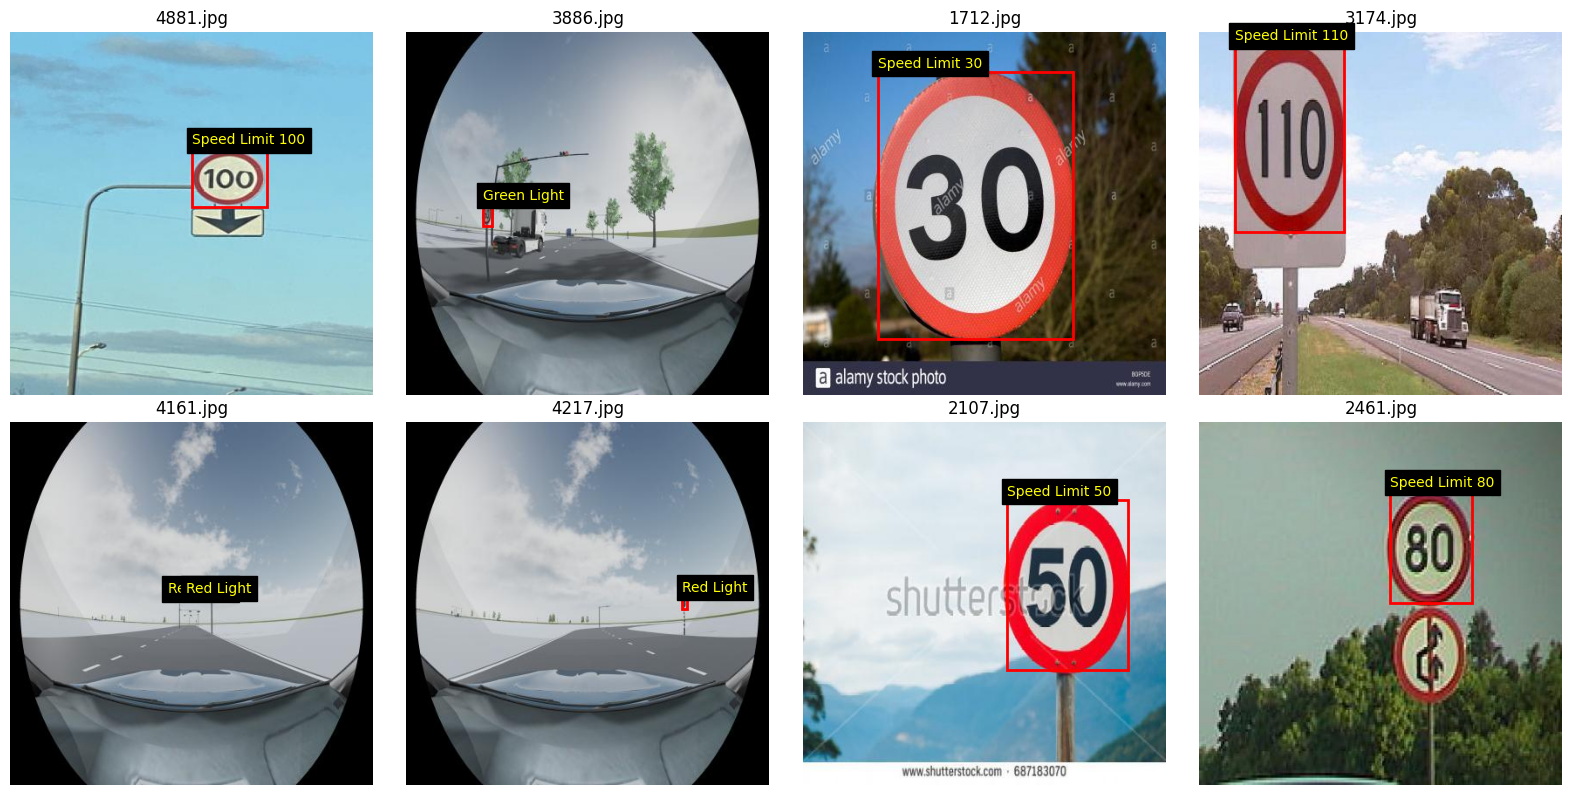

In [21]:
def display_samples(num_samples, training_img_path, training_labels_path):
  image_files = os.listdir(training_img_path)
  sample_files = random.sample(image_files, num_samples)

  cols = 4
  rows = (num_samples + cols - 1) // cols
  plt.figure(figsize=(16, 4 * rows))

  for i, img_name in enumerate(sample_files, 1):
    img_path = os.path.join(training_img_path, img_name)
    label_path = os.path.join(training_labels_path, img_name.replace(".jpg", ".txt"))

    img = plt.imread(img_path)
    h, w = img.shape[0], img.shape[1]

    ax = plt.subplot(rows, cols, i)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(img_name)

    if os.path.exists(label_path):
      with open(label_path, "r") as f:
        for line in f:
          cls, x_c, y_c, bw, bh = map(float, line.split())
          x_c *= w; y_c *= h
          bw  *= w; bh  *= h
          x_min = x_c - bw / 2
          y_min = y_c - bh / 2

          rect = Rectangle((x_min, y_min), bw, bh, linewidth=2, edgecolor='red', facecolor='none')
          ax.add_patch(rect)

          label = CLASS_NAMES[int(cls)]
          ax.text(x_min, y_min - 5, label, color='yellow', fontsize=10, backgroundcolor='black')

  plt.tight_layout()
  plt.show()

display_samples(8, train_images_dir, train_labels_dir)

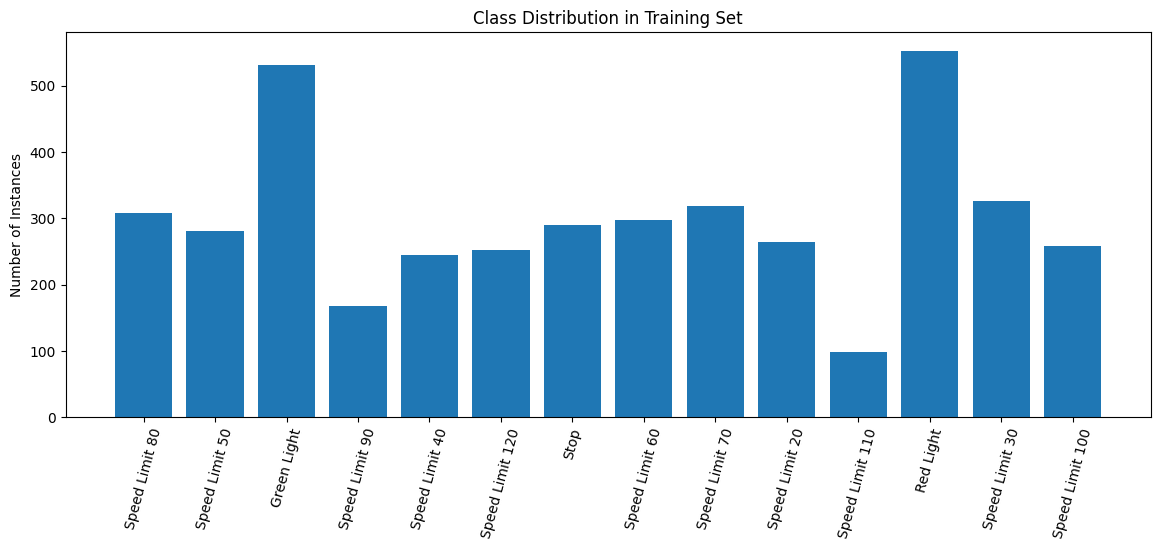

{0: 308,
 1: 281,
 2: 532,
 3: 168,
 4: 244,
 5: 252,
 6: 290,
 7: 297,
 8: 319,
 9: 264,
 10: 99,
 11: 553,
 12: 326,
 13: 258}

In [22]:
class_counts = {i: 0 for i in CLASS_NAMES.keys()}

for label_file in os.listdir(train_labels_dir):
  with open(os.path.join(train_labels_dir, label_file), "r") as f:
    for line in f:
      cls_id = int(line.split()[0])
      class_counts[cls_id] += 1

plt.figure(figsize=(14,5))
plt.bar(CLASS_NAMES.values(), class_counts.values())
plt.xticks(rotation=75, fontsize=10)
plt.ylabel("Number of Instances")
plt.title("Class Distribution in Training Set")
plt.show()

class_counts

**Identify any class imbalance and discuss how it might affect model training in your report.**
The class distribution shows a clear imbalance in the dataset. The most frequent classes, such as Red Light (553 samples) and Green Light (532 samples), appear more than five times as often as the least frequent class, Speed Limit 110 (99 samples). Several other classes, including Speed Limit 90 (168 samples), are also underrepresented compared to the majority. This imbalance may cause the model to become biased toward the more common classes, resulting in higher accuracy for them while producing more false negatives and lower mAP for the rare classes. As a result, the detector may struggle to correctly identify less frequent signs.

#### 1.2 Preprocess the Data

In [23]:
IMG_SIZE = 256   # or 128 if you want smaller

# 1) Get all training images
all_images = sorted(glob.glob(os.path.join(train_images_dir, "*.jpg")))

# 2) For each image, read its label file and get the first class id
labels = []
for img_path in all_images:
    base = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(train_labels_dir, base + ".txt")

    with open(label_path, "r") as f:
        line = f.readline().strip()

    class_id = int(line.split()[0]) if line else -1
    labels.append(class_id)

# 3) Stratified split: 70% train, 30% val
train_imgs, val_imgs, train_y, val_y = train_test_split(
    all_images,
    labels,
    test_size=0.3,
    random_state=42,
    stratify=labels
)

print("Train images:", len(train_imgs))
print("Val images:", len(val_imgs))

# 4) Preprocess function: resize + normalize to [0, 1]
def load_and_preprocess(img_path, img_size=IMG_SIZE):
    img = cv2.imread(img_path)                      # BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # to RGB
    img = cv2.resize(img, (img_size, img_size))     # resize
    img = img.astype("float32") / 255.0             # normalize
    return img

# ---- sanity check: make sure resize/normalize worked ----
sample_path = train_imgs[0]

orig = cv2.imread(sample_path)
print("Original shape:", orig.shape)

proc = load_and_preprocess(sample_path)
print("After preprocess shape:", proc.shape)
print("Pixel range:", proc.min(), "to", proc.max())

Train images: 2424
Val images: 1040
Original shape: (416, 416, 3)
After preprocess shape: (256, 256, 3)
Pixel range: 0.0 to 1.0


### 2. Baseline Methods

#### 2.1 Implementation of Baseline Object Recognition

In [24]:
print("Train images:", len(train_imgs))
print("Val images:", len(val_imgs))
print("Example train image:", train_imgs[0])
print("Example val image:", val_imgs[0])

# ---- 1) Save train/val image paths to text files for YOLO ----
train_list_path = "/content/train_images.txt"
val_list_path   = "/content/val_images.txt"

with open(train_list_path, "w") as f:
    for p in train_imgs:
        f.write(os.path.abspath(p) + "\n")

with open(val_list_path, "w") as f:
    for p in val_imgs:
        f.write(os.path.abspath(p) + "\n")

print("Saved:")
print("  train list ->", train_list_path)
print("  val list   ->", val_list_path)

# ---- 2) Build class name list in correct order (0,1,2,...) ----
# class_names is your dict: {0: '...', 1: '...', ...}
CLASS_NAMES = [CLASS_NAMES[i] for i in sorted(CLASS_NAMES.keys())]
num_classes = len(CLASS_NAMES)
print("Number of classes (nc):", num_classes)
print("Class order:", CLASS_NAMES)

# ---- 3) Create YOLO data.yaml ----
data_yaml_path = "/content/road_signs.yaml"

with open(data_yaml_path, "w") as f:
    f.write("path: /content\n")                # not critical since we use absolute paths
    f.write(f"train: {train_list_path}\n")
    f.write(f"val: {val_list_path}\n")
    f.write(f"nc: {num_classes}\n")
    f.write("names:\n")
    for name in CLASS_NAMES:
        f.write(f"  - {name}\n")

print("\n=== road_signs.yaml ===")
with open(data_yaml_path, "r") as f:
    print(f.read())

Train images: 2424
Val images: 1040
Example train image: /content/Road_Signs_Detection_Dataset/train/images/2532.jpg
Example val image: /content/Road_Signs_Detection_Dataset/train/images/3868.jpg
Saved:
  train list -> /content/train_images.txt
  val list   -> /content/val_images.txt
Number of classes (nc): 14
Class order: ['Speed Limit 80', 'Speed Limit 50', 'Green Light', 'Speed Limit 90', 'Speed Limit 40', 'Speed Limit 120', 'Stop', 'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 20', 'Speed Limit 110', 'Red Light', 'Speed Limit 30', 'Speed Limit 100']

=== road_signs.yaml ===
path: /content
train: /content/train_images.txt
val: /content/val_images.txt
nc: 14
names:
  - Speed Limit 80
  - Speed Limit 50
  - Green Light
  - Speed Limit 90
  - Speed Limit 40
  - Speed Limit 120
  - Stop
  - Speed Limit 60
  - Speed Limit 70
  - Speed Limit 20
  - Speed Limit 110
  - Red Light
  - Speed Limit 30
  - Speed Limit 100



Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/road_signs.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=roadsigns_yolov8n2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tr

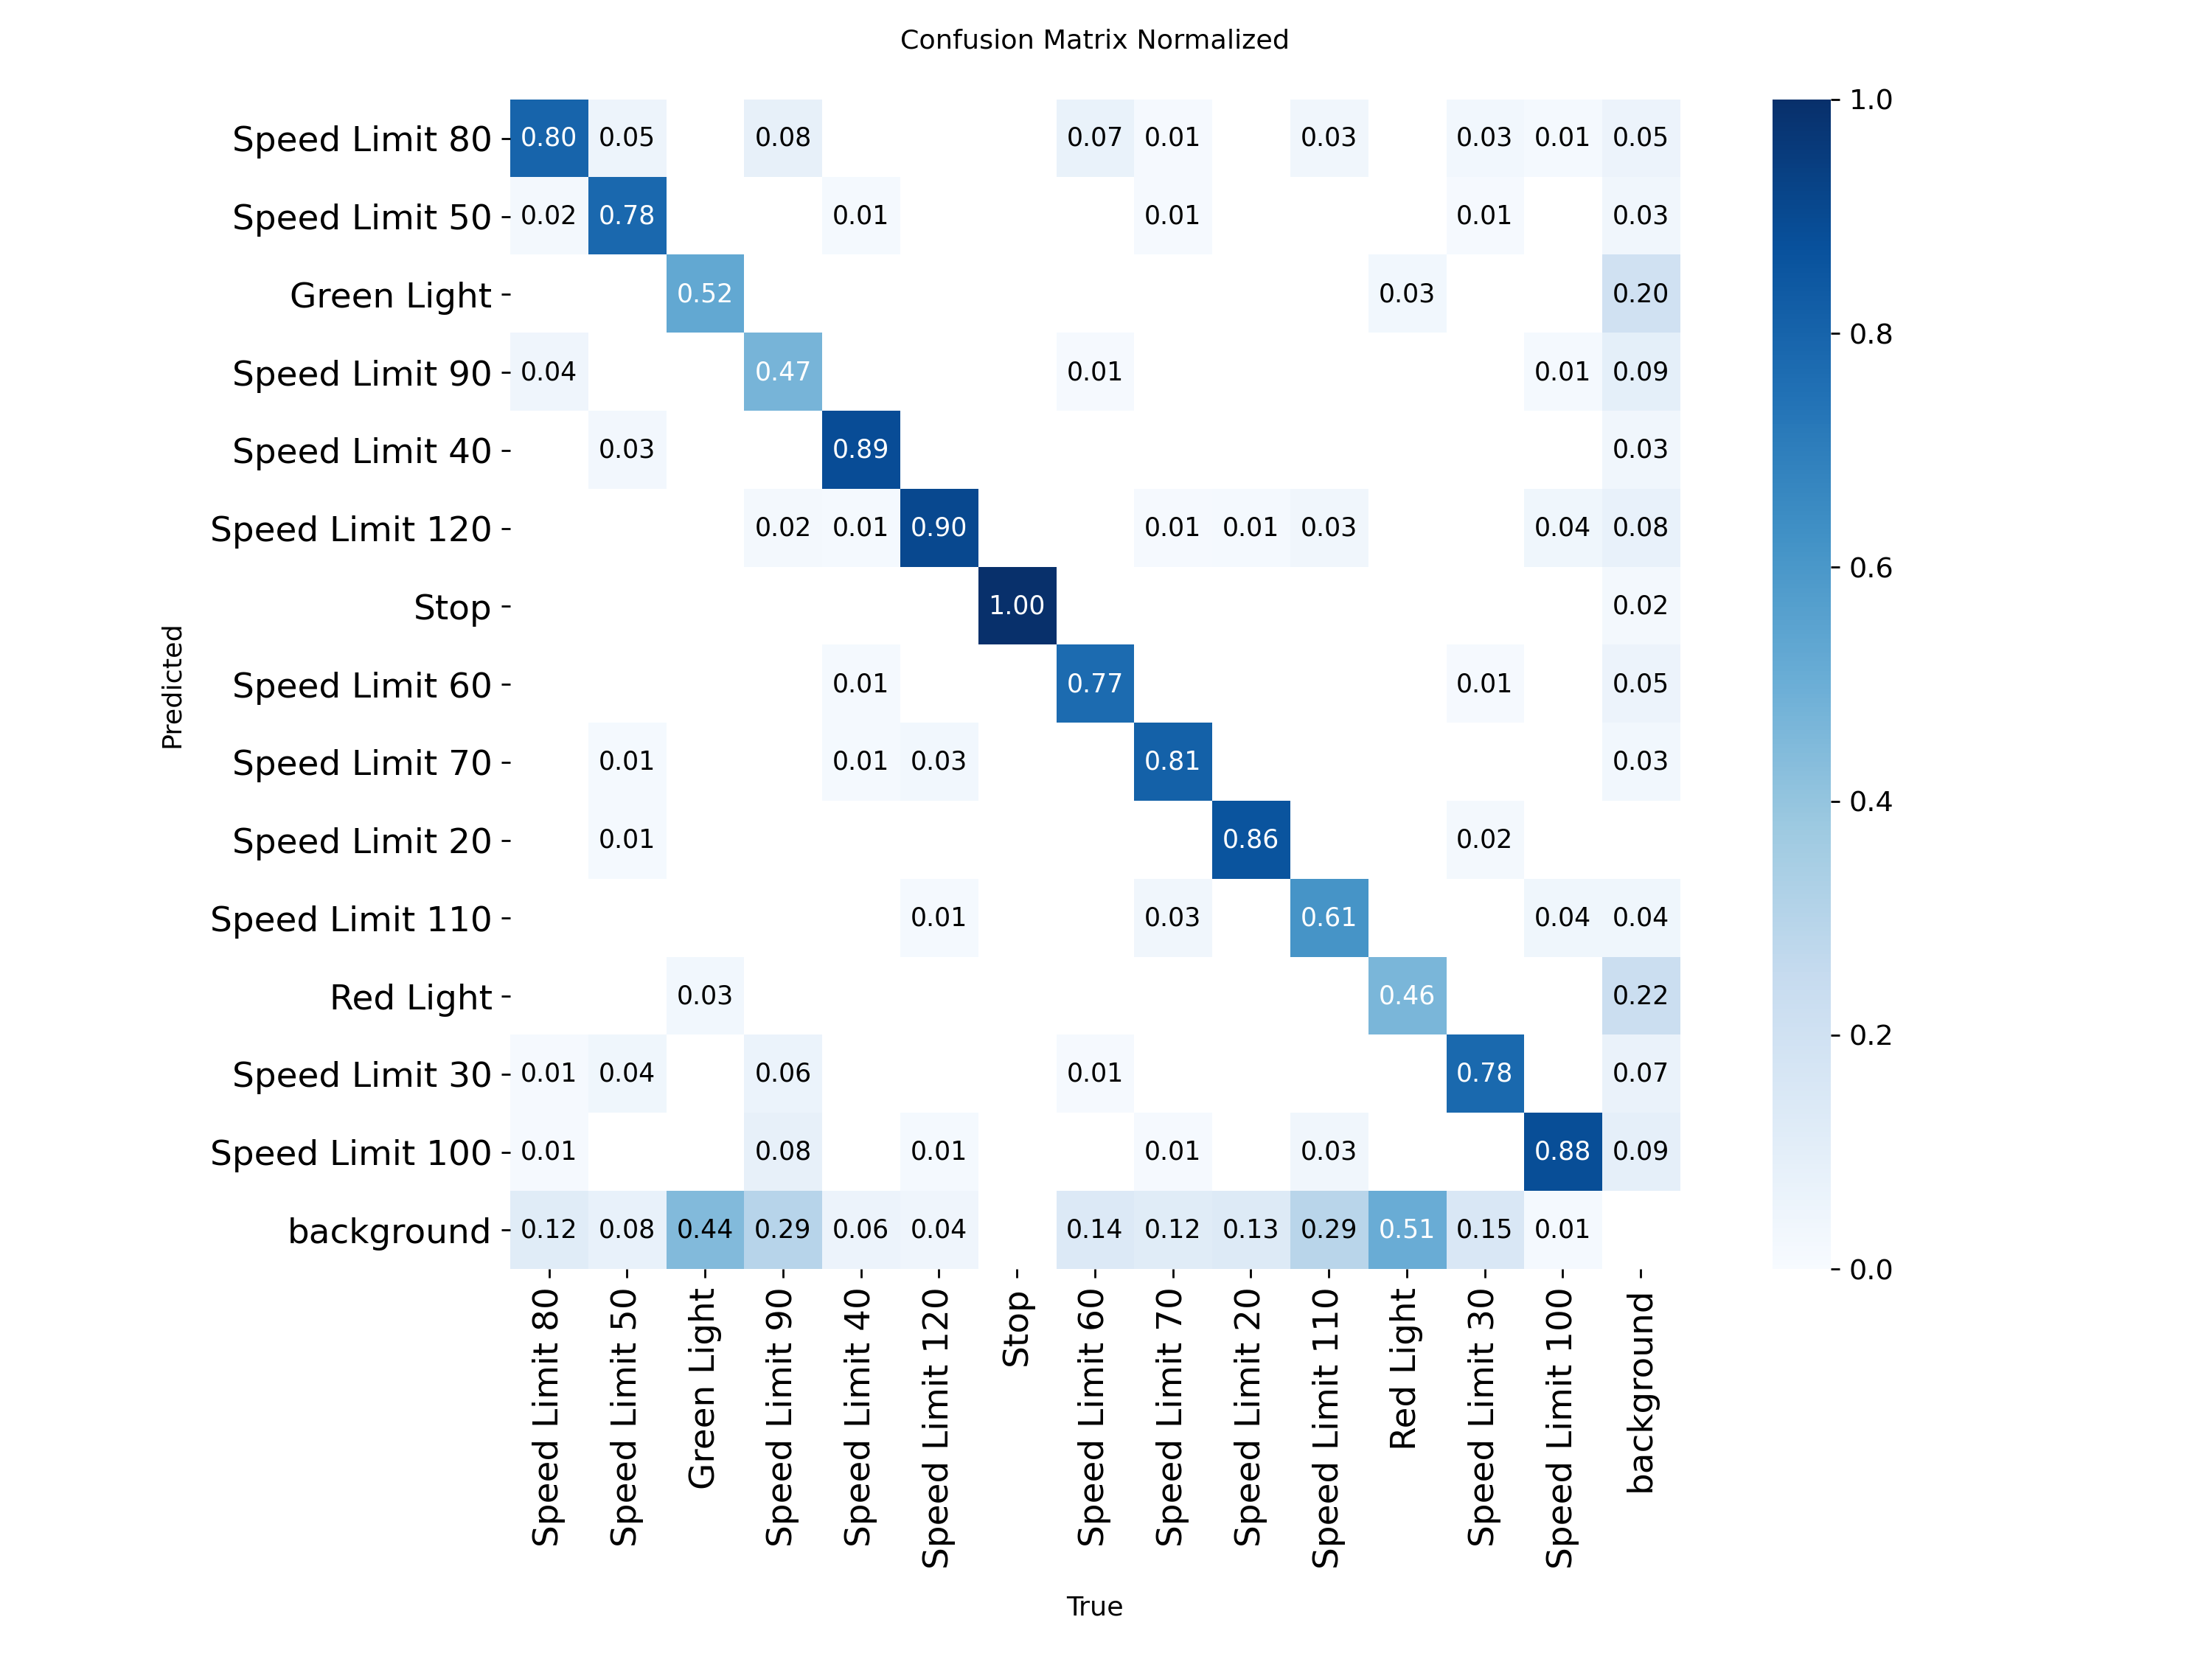

In [25]:
# 1) Load a pre-trained YOLOv8 model (COCO-pretrained)
model = YOLO("yolov8n.pt")   # you can switch to 'yolov8s.pt' if GPU memory allows

# 2) Fine-tune on our road sign dataset
results = model.train(
    data=data_yaml_path,   # uses the YAML we created
    imgsz=IMG_SIZE,        # 256 from your previous cell
    epochs=30,             # adjust if needed (epochs=30)
    batch=16,              # adjust if you get OOM errors
    lr0=1e-3,              # initial learning rate
    name="roadsigns_yolov8n",  # run name
    verbose=True
)

# 3) Evaluate on the validation split
metrics = model.val(
    data=data_yaml_path,
    imgsz=IMG_SIZE,
    split="val"   # explicitly use validation set
)

print("\n=== Detection metrics (YOLOv8) ===")
print("mAP@50:     ", metrics.box.map50)   # mAP at IoU 0.50
print("mAP@50-95:  ", metrics.box.map)     # mAP averaged 0.50:0.95

# Per-class mAP@50
per_class_map50 = metrics.box.maps  # array length = num_classes
print("Per-class mAP@50:", per_class_map50)
print("Mean mAP@50:     ", per_class_map50.mean())

# Per-class F1 score (some versions expose this)
if hasattr(metrics.box, "f1"):
    f1_per_class = metrics.box.f1        # shape: (num_classes,)
    print("Per-class F1:", f1_per_class)
    print("Mean F1:      ", f1_per_class.mean())
else:
    print("⚠️ This Ultralytics version does not expose per-class F1 directly.")

# 4) Confusion matrix (class-level misclassifications)
cm = metrics.confusion_matrix
cm.plot(normalize=True, save_dir=metrics.save_dir)

from IPython.display import Image, display
cm_path = os.path.join(metrics.save_dir, "confusion_matrix_normalized.png")
if os.path.exists(cm_path):
    display(Image(filename=cm_path))
else:
    print("Could not find confusion matrix image at:", cm_path)

#### 2.2 Analysis of Baseline Results

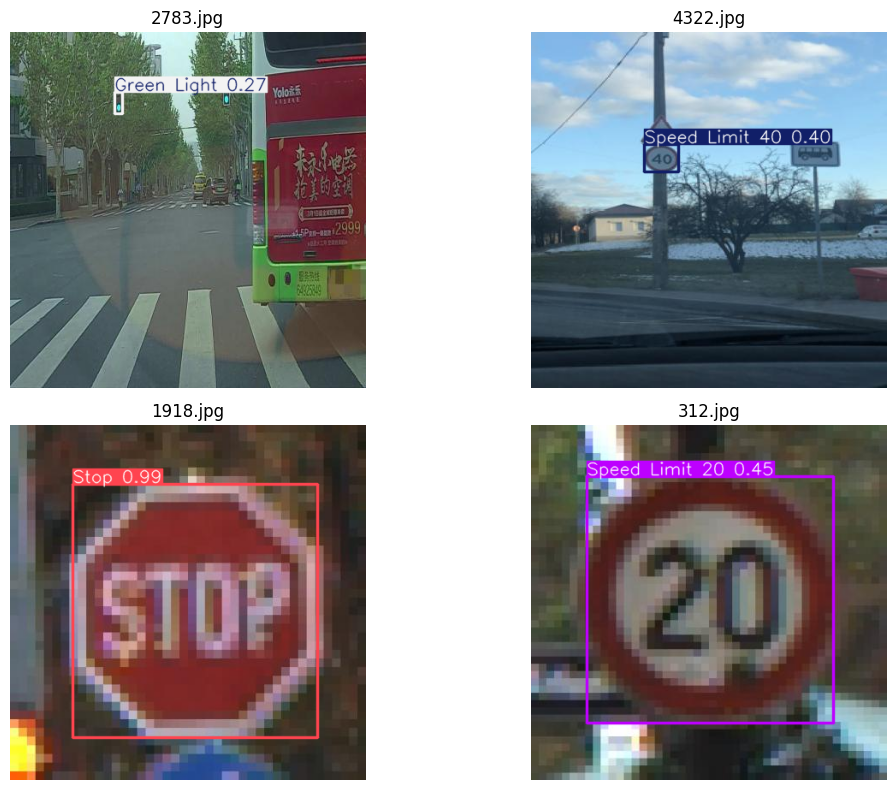

In [26]:
# 1) Load the best fine-tuned weights from your training run
best_weights = "/content/runs/detect/roadsigns_yolov8n/weights/best.pt"
best_model = YOLO(best_weights)

# 2) Pick a few validation images (val_imgs comes from your earlier split)
num_samples = 4
sample_val_imgs = random.sample(val_imgs, num_samples)

# 3) Run inference and show annotated predictions
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(sample_val_imgs, 1):
    results = best_model(img_path, conf=0.25, verbose=False)
    annotated = results[0].plot()              # BGR image with boxes + labels
    annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 2, i)
    plt.imshow(annotated)
    plt.title(os.path.basename(img_path))
    plt.axis("off")

plt.tight_layout()
plt.show()

### 3. Model Implementation

#### 3.1 Choose a Model

In [27]:
# dataset_root = "/content/Road_Signs_Detection_Dataset"

# # train_images_dir = os.path.join(dataset_root, "train", "images")
# # train_labels_dir = os.path.join(dataset_root, "train", "labels")
# # test_images_dir  = os.path.join(dataset_root, "test", "images")

# print("dataset roots: ", dataset_root)
# print("Train images dir:", train_images_dir)
# print("Train labels dir:", train_labels_dir)
# print("Test images dir:", test_images_dir)

!pip install -q torch torchvision

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as F

In [28]:
class RoadSignsDataset(Dataset):
  def __init__(self, image_paths, labels_dir, transforms=None):
    self.image_paths = image_paths
    self.labels_dir = labels_dir
    self.transforms = transforms

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img_path = self.image_paths[idx]

    # load image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    # load YOLO labels
    base = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(self.labels_dir, base + ".txt")

    boxes = []
    labels = []

    if os.path.exists(label_path):
      with open(label_path, "r") as f:
        for line in f:
          cls, x_c, y_c, bw, bh = map(float, line.split())

          # YOLO normalized coordinates -> pixel coordinates
          x_c_abs = x_c * width
          y_c_abs = y_c * height
          bw_abs  = bw * width
          bh_abs  = bh * height

          x_min = x_c_abs - bw_abs / 2
          y_min = y_c_abs - bh_abs / 2
          x_max = x_c_abs + bw_abs / 2
          y_max = y_c_abs + bh_abs / 2

          boxes.append([x_min, y_min, x_max, y_max])

          # shift all labels by 1
          labels.append(int(cls) + 1)

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {
      "boxes":  boxes,
      "labels": labels,
    }

    if self.transforms is not None:
      # Fix: Pass both image and target to the transforms
      image, target = self.transforms(image, target)

    return image, target

In [29]:
def collate_fn(batch):
  return tuple(zip(*batch))

# train_dataset = RoadSignsDataset(train_imgs, train_labels_dir, transforms=torchvision.transforms.ToTensor())
# val_dataset = RoadSignsDataset(val_imgs, train_labels_dir, transforms=torchvision.transforms.ToTensor())

# # Fix: Generate indices directly, as RoadSignsDataset does not have an 'indices' attribute
# # And pass train_dataset directly to Subset, not train_dataset.dataset
# subset_indices = list(range(500)) # Take the first 500 indices
# train_subset = torch.utils.data.Subset(train_dataset, subset_indices)

# train_loader = DataLoader(
#   train_subset,
#   batch_size=4,     # change this if you want
#   shuffle=True,
#   num_workers=2,
#   collate_fn=collate_fn
# )

# # print
# print("Train dataset size:", len(train_dataset))
# print("Val dataset size:", len(val_dataset))

# images, targets = next(iter(train_loader))
# print("One batch - num images:", len(images))
# print("Image shape:", images[0].shape)
# print("Boxes shape:", targets[0]["boxes"].shape)
# print("Labels:", targets[0]["labels"])

In [30]:
NUM_CLASSES = 14 + 1 # +1 for the background

# Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace classification/regression head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features,
    NUM_CLASSES
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Device used: ", device)

Device used:  cuda


#### 3.2 Data Augmentation

In [31]:
from PIL import Image

class ComposeTransforms(object):
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, image, target):
    for t in self.transforms:
      if isinstance(t, torchvision.transforms.ToTensor):
        image = t(image)
      else:
        image, target = t(image, target)
    return image, target

class RandomHorizontalFlip(object):
  def __init__(self, prob=0.5):
    self.prob = prob

  def __call__(self, image, target):
    if random.random() < self.prob:
      pil_image = Image.fromarray(image)
      flipped_pil_image = F.hflip(pil_image)
      image = np.array(flipped_pil_image) # convert back to numpy (H, W, C)

      width = image.shape[1]
      boxes = target["boxes"]

      # ensure boxes is not empty before attempting to modify
      if len(boxes) > 0:
        x_min_orig = boxes[:, 0].clone() # clone to avoid in-place modification issues if tensor is a view
        x_max_orig = boxes[:, 2].clone()
        boxes[:, 0] = width - x_max_orig
        boxes[:, 2] = width - x_min_orig

        target["boxes"] = boxes

    return image, target

train_transforms = ComposeTransforms([
    RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

val_transforms = ComposeTransforms([
    torchvision.transforms.ToTensor()
])

train_dataset = RoadSignsDataset(train_imgs, train_labels_dir, transforms=train_transforms)
val_dataset = RoadSignsDataset(val_imgs, train_labels_dir, transforms=val_transforms)

# # testing purposes
# subset_indices = list(range(500)) # Take the first 500 indices
# train_subset = torch.utils.data.Subset(train_dataset, subset_indices)
# val_subset = torch.utils.data.Subset(val_dataset, subset_indices)

train_loader = DataLoader(
  train_dataset,     # change this before submission
  batch_size=4,     # change this if you want
  shuffle=True,
  num_workers=2,
  collate_fn=collate_fn
)

val_loader = DataLoader(
  val_dataset,       # change this before submission
  batch_size=4,     # change this if you want
  shuffle=False,
  num_workers=2,
  collate_fn=collate_fn
)

# print
print("Train dataset size:", len(train_dataset))
print("Val dataset size:", len(val_dataset))

# # testing purposes
# print("Train subset size:", len(train_subset))
# print("Val subset size:", len(val_subset))

Train dataset size: 2424
Val dataset size: 1040


#### 3.3 Train the Model

In [32]:
from torch.nn.modules import loss
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(
    params,
    lr=0.005,        # change this if you want
    momentum=0.9,
    weight_decay=0.0005,
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.1
)

def train_each_epoch(model, optimizer, data_loader, device):
  model.train()
  epoch_loss = 0.0

  for images, targets in data_loader:
    images = [img.to(device) for img in images]
    # targets is a list of dictionaries, iterate over each dictionary and move its contents to device
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    epoch_loss += losses.item()

  avg_loss = epoch_loss / len(data_loader)
  return avg_loss

In [ ]:
num_epochs = 15      # can modify this if you want

train_losses = []

for epoch in range(num_epochs):
  print(f"Epoch [{epoch+1}/{num_epochs}]")
  train_loss = train_each_epoch(model, optimizer, train_loader, device)
  train_losses.append(train_loss)

  lr_scheduler.step()

  print(f"Training loss: {train_loss:.4f}")

Epoch [1/15]
Training loss: 0.2386
Epoch [2/15]
Training loss: 0.1477
Epoch [3/15]
Training loss: 0.1280
Epoch [4/15]
Training loss: 0.1145
Epoch [5/15]
Training loss: 0.0991
Epoch [6/15]
Training loss: 0.0757
Epoch [7/15]
Training loss: 0.0693
Epoch [8/15]


### 4. Model Evaluation

#### 4.1 Evaluate Performance

In [ ]:
def compute_iou(box1, box2):
  # reshape for broadcasting
  b1 = box1[:, None, :] # (N, 1, 4)
  b2 = box2[None, :, :] # (1, M, 4)

  # overlapping region coordinates
  overlap_x1 = torch.maximum(b1[..., 0], b2[..., 0])
  overlap_y1 = torch.maximum(b1[..., 1], b2[..., 1])
  overlap_x2 = torch.minimum(b1[..., 2], b2[..., 2])
  overlap_y2 = torch.minimum(b1[..., 3], b2[..., 3])

  overlap_w = (overlap_x2 - overlap_x1).clamp(min=0)
  overlap_h = (overlap_y2 - overlap_y1).clamp(min=0)
  inter_area = overlap_w * overlap_h

  # compute areas of each box
  area1 = (b1[..., 2] - b1[..., 0]) * (b1[..., 3] - b1[..., 1])
  area2 = (b2[..., 2] - b2[..., 0]) * (b2[..., 3] - b2[..., 1])

  union_area = area1 + area2 - inter_area

  # iou calculation
  iou = inter_area / (union_area + 1e-6)

  return iou

In [ ]:
model.eval()

true_labels = []
all_pred_labels = []
eval_data = []

iou_threshold = 0.5

with torch.no_grad():
  for images, targets in val_loader:
    images = [img.to(device) for img in images]
    results = model(images)

    for result, target in zip(results, targets):
      # ground truth
      gt_boxes = target["boxes"].cpu()
      gt_labels = target["labels"].cpu()

      # predictions for the current image
      pred_boxes_curr_img = result["boxes"].cpu()
      pred_labels_curr_img = result["labels"].cpu()
      pred_scores_curr_img = result["scores"].cpu()

      eval_data.append({
          "gt_boxes": gt_boxes,
          "gt_labels": gt_labels,
          "pred_boxes": pred_boxes_curr_img,
          "pred_labels": pred_labels_curr_img,
          "pred_scores": pred_scores_curr_img,
      })

      # compute iou matrix (shape: num_gt_boxes x num_pred_boxes)
      iou_matrix = compute_iou(gt_boxes, pred_boxes_curr_img)

      matched_gt = set()

      # iterate over predicted boxes/labels for the current image
      for idx, pred_label_value in enumerate(pred_labels_curr_img):
        if iou_matrix.numel() > 0: # check if iou_matrix is not empty
          ious_for_current_pred = iou_matrix[:, idx]
          best_iou, g_idx = torch.max(ious_for_current_pred, dim=0)

          if best_iou > iou_threshold and g_idx.item() not in matched_gt:
            true_labels.append(int(gt_labels[g_idx].item()))
            all_pred_labels.append(int(pred_label_value.item()))
            matched_gt.add(g_idx.item())
          else:
            true_labels.append(0) # assign 0 (background) for 'true' label if no match
            all_pred_labels.append(int(pred_label_value.item()))
        else:
          true_labels.append(0)
          all_pred_labels.append(int(pred_label_value.item()))

print("Finished collecting validation predictions.")
print("Total matched predictions:", len(all_pred_labels))

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

NUM_CLASSES = 14

# drop background
filtered_true = [t for t in true_labels if t != 0]
filtered_pred = [p for t, p in zip(true_labels, all_pred_labels) if t != 0]

# compute f1 macro
f1_macro = f1_score(filtered_true, filtered_pred, average='macro')
print("Faster R-CNN F1 (macro, classes 1–14):", f1_macro)

# confusion matrix
val_img_labels = list(range(1, NUM_CLASSES + 1))
cm = confusion_matrix(filtered_true, filtered_pred, labels=val_img_labels)

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = [CLASS_NAMES[i-1] for i in val_img_labels]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(
    ax = ax,
    xticks_rotation="vertical",
    cmap="Blues",
    values_format=".2f"
)
plt.title("Faster R-CNN – Confusion Matrix (validation set)")
plt.tight_layout()
plt.show()

In [ ]:
def compute_ap(recall, precision):
  recall = np.concatenate(([0.], recall, [1.]))
  precision = np.concatenate(([0.], precision, [0.]))

  # make precision non-increasing
  for i in range(precision.size - 1, 0, -1):
    precision[i-1] = np.maximum(precision[i-1], precision[i])

  # area under PR curve
  idx = np.where(recall[1:] != recall[:-1])[0]
  ap = np.sum((recall[idx + 1] - recall[idx]) * precision[idx + 1])
  return ap

def compute_map_multiclass(eval_data, iou_threshold, num_classes=NUM_CLASSES):
  aps_per_thr = []

  for thr in iou_threshold:
    ap_this_thr = []

    for c in range (1, num_classes + 1):
      scores = []
      tp = []
      fp = []
      n_pos = 0

      for d in eval_data:
        gt_boxes = d["gt_boxes"]
        gt_labels = d["gt_labels"]
        pred_boxes = d["pred_boxes"]
        pred_labels = d["pred_labels"]
        pred_scores = d["pred_scores"]

        # select gt and predictions of class c
        gt_mask = (gt_labels == c)
        pred_mask = (pred_labels == c)

        gt_boxes = gt_boxes[gt_mask]
        pred_boxes = pred_boxes[pred_mask]
        pred_scores = pred_scores[pred_mask]

        n_pos += gt_boxes.shape[0]

        iou = compute_iou(pred_boxes, gt_boxes)  # shape: [num_pred, num_gt]

        used_gt = set()

        for i in range(pred_boxes.shape[0]):
          scores.append(pred_scores[i].item())

          pred_ious = iou[i]
          if pred_ious.numel() > 0: # check if there are any IoU values
            max_iou, j = torch.max(pred_ious, dim=0)

            if max_iou > thr and j.item() not in used_gt:
              tp.append(1)
              fp.append(0)
              used_gt.add(j.item())
            else:
              tp.append(0)
              fp.append(1)
          else: # no ground truth boxes for this class (FP)
            tp.append(0)
            fp.append(1)

      scores = np.array(scores)
      tp = np.array(tp)
      fp = np.array(fp)

      # sort
      sort_idx = np.argsort(-scores)
      tp = tp[sort_idx]
      fp = fp[sort_idx]

      tp_cum = np.cumsum(tp)
      fp_cum = np.cumsum(fp)

      recall = tp_cum / (n_pos + 1e-6)
      precision = tp_cum / (tp_cum + fp_cum + 1e-6)

      ap_c = compute_ap(recall, precision)
      ap_this_thr.append(ap_c)

    aps_per_thr.append(ap_this_thr)

  aps_per_thr = np.array(aps_per_thr)
  mean_map = np.nanmean(aps_per_thr)
  return mean_map, aps_per_thr

# mAP@50
map50, aps_50 = compute_map_multiclass(eval_data, [0.5])
# mAP@50-95
map_50_95, aps_50_95 = compute_map_multiclass(eval_data, np.arange(0.5, 1.0, 0.05))

print("mAP@50:     ", map50)
print("mAP@50–95:  ", map_50_95)

#### 4.2 Visualize Results

In [ ]:
from matplotlib import patches

def show_prediction_on_image(img_tensor, boxes, labels, scores, score_thresh=0.5):
  img_np = img_tensor.permute(1, 2, 0).numpy()

  fig, ax = plt.subplots(figsize=(6, 6))
  ax.imshow(img_np)
  ax.axis("off")

  # move everything to numpy for easier looping
  boxes  = boxes.cpu().numpy()
  labels = labels.cpu().numpy()
  scores = scores.cpu().numpy()

  for box, lab, sc in zip(boxes, labels, scores):
    if sc < score_thresh:
        continue

    x1, y1, x2, y2 = box
    rect = patches.Rectangle(
        (x1, y1),
        x2 - x1,
        y2 - y1,
        linewidth=2,
        edgecolor="red",
        facecolor="none",
    )
    ax.add_patch(rect)

    # labels are 1..14 in your setup
    class_name = CLASS_NAMES[lab - 1]
    text = f"{class_name}  {sc:.2f}"

    ax.text(
        x1,
        y1 - 3,
        text,
        fontsize=8,
        color="yellow",
        bbox=dict(facecolor="black", alpha=0.6),
    )

  plt.tight_layout()
  plt.show()



model.eval()

def show_val_predictions(model, val_loader, device, num_images=5, score_thresh=0.5):
  shown = 0
  with torch.no_grad():
    for images, targets in val_loader:
      # move the whole batch to device once
      images_gpu = [img.to(device) for img in images]
      outputs = model(images_gpu)

      # go through each image + its prediction in this batch
      for img_tensor_gpu, out in zip(images_gpu, outputs):
        if shown >= num_images:
          return

        # bring image back to CPU for plotting
        img_tensor_cpu = img_tensor_gpu.cpu()

        show_prediction_on_image(
            img_tensor_cpu,
            out["boxes"],
            out["labels"],
            out["scores"],
            score_thresh=score_thresh,
        )

        shown += 1

  print(f"Displayed {shown} validation predictions.")


show_val_predictions(model, val_loader, device, num_images=5, score_thresh=0.5)

#### 4.3 Generalization Test

In [ ]:
from PIL import Image
import torchvision.transforms as T

uploaded = files.upload()
external_test_img_path = list(uploaded.keys())[0]
print('uploaded image: ', external_test_img_path)

def generalization_test(model, img_path, device, score_threshold=0.5):
  image_rgb = Image.open(img_path).convert("RGB")
  img_tensor = T.ToTensor()(image_rgb)

  model.eval()
  with torch.no_grad():
    output = model([img_tensor.to(device)])[0]

  boxes  = output["boxes"].cpu()
  labels = output["labels"].cpu()
  scores = output["scores"].cpu()

  show_prediction_on_image(img_tensor, boxes, labels, scores)

generalization_test(model, external_test_img_path, device, score_threshold=0.5)

### 5.  Prediction & Kaggle Competition

In [ ]:
DATASET_ROOT = "/content/Road_Signs_Detection_Dataset"
TEST_IMAGES_DIR = os.path.join(DATASET_ROOT, "test", "images")
print('Test images directory: ', TEST_IMAGES_DIR)

class RoadSignsTestDataset(Dataset):
  def __init__(self, img_dir, transforms=None):
    self.img_dir = img_dir
    self.img_files = sorted(
        [f for f in os.listdir(img_dir) if f.lower().endswith(".jpg")]
    )
    self.transforms = transforms

  def __len__(self):
    return len(self.img_files)

  def __getitem__(self, idx):
    file_name = self.img_files[idx]
    img_path  = os.path.join(self.img_dir, file_name)

    img = Image.open(img_path).convert("RGB")
    if self.transform is not None:
      img = self.transform(img)

    image_id = os.path.splitext(file_name)[0]
    return img, image_id

def collate_fn_test(batch):
  images, ids = zip(*batch)
  return list(images), list(ids)

test_dataset = RoadSignsTestDataset(TEST_IMAGES_DIR, transform=torchvision.transforms.ToTensor())
print("Number of test images:", len(test_dataset))

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn_test,
)

In [ ]:
model.eval()
confidence_threshold = 0.3
predictions = {}

with torch.no_grad():
  for batch_imgs, batch_ids in test_loader:
    # move images to device
    batch_imgs_device = [img.to(device) for img in batch_imgs]

    outputs = model(batch_imgs_device)

    # loop through each image in the batch
    for img_tensor, output, image_id in zip(batch_imgs, outputs, batch_ids):
      # move image back to CPU for plotting
      _, H, W = img_tensor.shape

      boxes = output["boxes"].cpu()
      labels = output["labels"].cpu()
      scores = output["scores"].cpu()

      dets_for_img = []

      # loop through each detected box in the image
      for box, lab, sc in zip(boxes, labels, scores):
        if sc < confidence_threshold: # skip low-confidence
          continue

        x1, y1, x2, y2 = box.tolist()

        # centralize
        bw = x2 - x1
        bh = y2 - y1
        xc = x1 + bw / 2.0
        yc = y1 + bh / 2.0

        # normalize to [0,1]
        xc_norm = xc / W
        yc_norm = yc / H
        bw_norm = bw / W
        bh_norm = bh / H

        class_id = int(lab.item()) - 1

        dets_for_img.append({
            "ID": image_id,
            "class_label": class_id,
            "x_center": float(xc_norm),
            "y_center": float(yc_norm),
            "width": float(bw_norm),
            "height": float(bh_norm),
            "score": float(sc.item())
        })

      # sort (descending)
      dets_for_img.sort(key=lambda d: d["score"], reverse=True)
      predictions[image_id] = dets_for_img

print("Collected predictions for", len(predictions), "test images.")

In [ ]:
# load sample submission csv file
uploaded = files.upload()
sample_submission_csv_path = list(uploaded.keys())[0]
print('Sample submission csv file uploaded successfully: ', sample_submission_csv_path)

sample_df = pd.read_csv(sample_submission_csv_path)
print("sample_submission shape:", sample_df.shape)
print(sample_df.head())

In [ ]:
# converting predictions into Kaggle format: ID, class_label, x_center, y_center, width, height

def split_kaggle_id(kaggle_id):
    parts = kaggle_id.split("_")
    img_id = "_".join(parts[:-1])
    idx = int(parts[-1])
    return img_id, idx

rows = []

for _, row in sample_df.iterrows():
    kaggle_id = row["ID"]
    img_id, det_idx = split_kaggle_id(kaggle_id)

    det_list = predictions.get(img_id, [])

    if det_idx < len(det_list):
        det = det_list[det_idx]
        rows.append({
            "ID": kaggle_id,
            "class_label": det["class_label"],
            "x_center": det["x_center"],
            "y_center": det["y_center"],
            "width": det["width"],
            "height": det["height"],
        })
    else:
        rows.append({
            "ID": kaggle_id,
            "class_label": -1,
            "x_center": 0.0,
            "y_center": 0.0,
            "width": 0.0,
            "height": 0.0,
        })

final_df = pd.DataFrame(rows)
final_df = final_df.sort_values("ID")

final_df.to_csv("kaggle_submission_group50.csv", index=False)
files.download("kaggle_submission_group50.csv")

print("Saved submission with", len(final_df), "rows.")
print("Submission file successfully downloaded to your computer.")